## Segmentation

### Generate Mask

In [1]:
import numpy as np
import cv2

In [2]:
def generate_circular_mask(img):
    # 1. get length `m` and width `n` of input img
    n = img.shape[0];
    m = img.shape[1];
#     print(n,m)

    # 2. divide `m` into equal 16 parts and call each unit as `lu`
    lu = m/16
#     print(lu)

    # 3. divide `n` into equal 16 parts and call each unit as `wu`
    wu = n/16
#     print(wu)

    # 4. `a` = (`lu`*14) /2    (lu*14 will get the major axis, to get semi major axis of ellipse,, need to divide by 2)
    a = int(lu * 14 /2)
#     print(a)

    # 5. `b` = (`wu`*12) /2    (wu*12 will get the minor axis, to get semi minor axis of ellipse, need to divide by 2)
    b = int(wu * 12 /2)
#     print(b)

    circular_mask = np.zeros((n,m), dtype=np.uint8)
#     print(circular_mask.shape)

    cv2.ellipse(circular_mask, (m // 2, n // 2), (a, b), 0, 0, 360, (255, 255, 255),thickness = -1)
#     cv2.imshow("test", circular_mask)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    ## input img : 256*256
    ## a=112, b=96, h=128, k=128

    return circular_mask

### Segmentation functiom

- no need anymore, since not going to embed in RONI

In [3]:
 def segmentation(img, mask):

    mask_inv = cv2.bitwise_not(mask)

    roi = cv2.bitwise_and(img,img, mask=mask)
    roni = cv2.bitwise_and(img,img, mask=mask_inv)

    return (roi, roni)

## Embed Function

### Embed Function

In [9]:
def embed_watermark(orig_image, watermark):
    watermark = cv2.resize(watermark, (orig_image.shape[0], orig_image.shape[1]))
    
    ## Ensure watermark in binary
    watermark = (watermark > 128).astype(np.uint8) # Convert to binary (0 or 1)
    
    ## use mask to get roi
    mask = generate_circular_mask(orig_image)
    mask = (mask > 128).astype(np.uint8) # Convert to binary (0 or 1)
    
    ## change to 16bits, to retain img data
    mask_16 = mask.astype(np.uint16)
    watermark_16 = watermark.astype(np.uint16)
    
    # use mask, to embed in ROI only
    ## interprete from left to right
    ## img_roi & ~mask --> if it is px needed to be embed(mask=1), turn LSB to 0 (thats why ~mask)
    ## watermark & mask --> if it is px needed to be embed (mask=1), the intensity value depends on watermark
    watermarked_img = orig_image & ~mask_16 | (watermark_16 & mask_16)
    
    return watermarked_img
    
    

### Extract Function

In [10]:
def extract_watermark(orig_image):

    ## use mask to get roi
    mask = generate_circular_mask(orig_image)
    mask = (mask > 128).astype(np.uint8) # Convert to binary (0 or 1)
      
    # Extract LSB where mask is 1
    extracted_bin_img = orig_image.astype(np.uint16) & mask

    # Convert to proper pixel values for viewing (scale to 0-255)
    extracted_watermark = extracted_bin_img * 255
    
    return extracted_watermark

## simplified dicom image operation method

In [11]:
import pydicom

def load_dicom(path):
    ds = pydicom.dcmread(path)
    image = ds.pixel_array
    return image, ds

def save_dicom(path, image, original_dicom):
    original_dicom.PixelData = image.astype(np.uint16).tobytes()
    original_dicom.save_as(path)


## Test

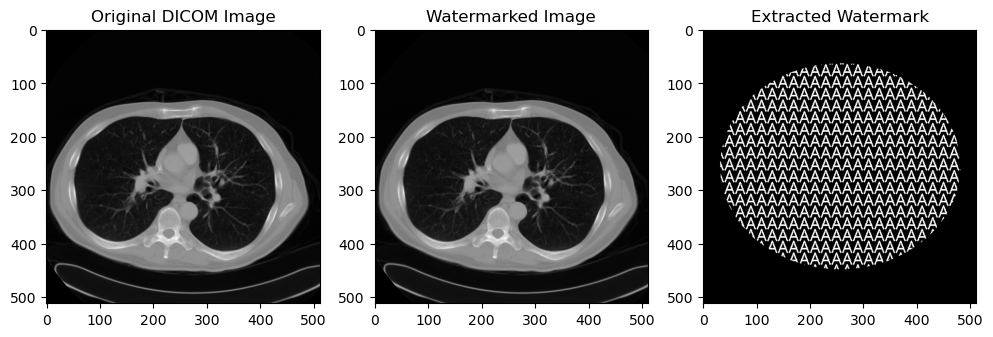

In [12]:
dicom_path = "medical-img.dcm"
watermark_path = "512_binary_img.png"

dicom_image, ds = load_dicom(dicom_path)

watermark = cv2.imread(watermark_path, cv2.IMREAD_GRAYSCALE)
watermarked_image = embed_watermark(dicom_image, watermark)

extracted_watermark = extract_watermark(watermarked_image)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(dicom_image, cmap='gray')
plt.title('Original DICOM Image')
plt.subplot(132)
plt.imshow(watermarked_image, cmap='gray')
plt.title('Watermarked Image')
plt.subplot(133)
plt.imshow(extracted_watermark, cmap='gray')
plt.title('Extracted Watermark')
plt.show()

## Calculate PSNR

In [8]:
psnr_value = cv2.PSNR(dicom_image, watermarked_image)
print(f"PSNR Value: {psnr_value} dB")

PSNR Value: 54.02226443435916 dB


## Attack

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_attacks_and_extract(img, extract_function):

    attacks = {
        "Without Attack": lambda x: x,  # No attack on the image
        "Gaussian Noise": lambda x: cv2.add(x, np.random.normal(0, 10, x.shape).astype(np.uint8)),
        "Minimal Gaussian Blur": lambda x: cv2.GaussianBlur(x, (3, 3), 0),  # Very light Gaussian blur
        "Median Filtering": lambda x: cv2.medianBlur(x, 3),  # Light median filter
        "JPEG Compression": lambda x: jpeg_compression(x, quality=85),  # Slight compression
        "Scaling Attack": lambda x: scale_down_up(x),
        "Very Light Smoothing": lambda x: cv2.blur(x, (2, 2))  # Very slight smoothing
    }
    
    # Initialize plotting
    num_attacks = len(attacks)
    fig, axs = plt.subplots(num_attacks, 2, figsize=(10, 2 * num_attacks))  # 2 columns per attack

    for i, (attack_name, attack_function) in enumerate(attacks.items()):
        # Apply the attack
        attacked_img = attack_function(img.copy())
        # Extract data using the provided extraction function
        extracted_img = extract_function(attacked_img)
        # Show the attacked image
        axs[i, 0].imshow(attacked_img, cmap='gray')
        axs[i, 0].set_title(f"{attack_name} - Attacked")
        axs[i, 0].axis('off')
        # Show the extracted image
        axs[i, 1].imshow(extracted_img, cmap='gray')
        axs[i, 1].set_title(f"{attack_name} - Extracted")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


def jpeg_compression(image, quality=90):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    result, encimg = cv2.imencode('.jpg', image, encode_param)
    decimg = cv2.imdecode(encimg, 1)
    return cv2.cvtColor(decimg, cv2.COLOR_BGR2GRAY)

def scale_down_up(image, scale_factor=0.5):
    height, width = image.shape
    resized_down = cv2.resize(image, (int(width * scale_factor), int(height * scale_factor)), interpolation=cv2.INTER_LINEAR)
    resized_up = cv2.resize(resized_down, (width, height), interpolation=cv2.INTER_LINEAR)
    return resized_up

def dummy_extract_function(image):
    # Placeholder for your actual data extraction function
    # Extract LSB where mask is 1
    extracted_bin_img = (image & circular_mask_bits) & 1

    # Convert to proper pixel values for viewing (scale to 0-255)
    extracted_bin_img *= 255
    
    return extracted_bin_img  # This should be replaced with actual extraction logic

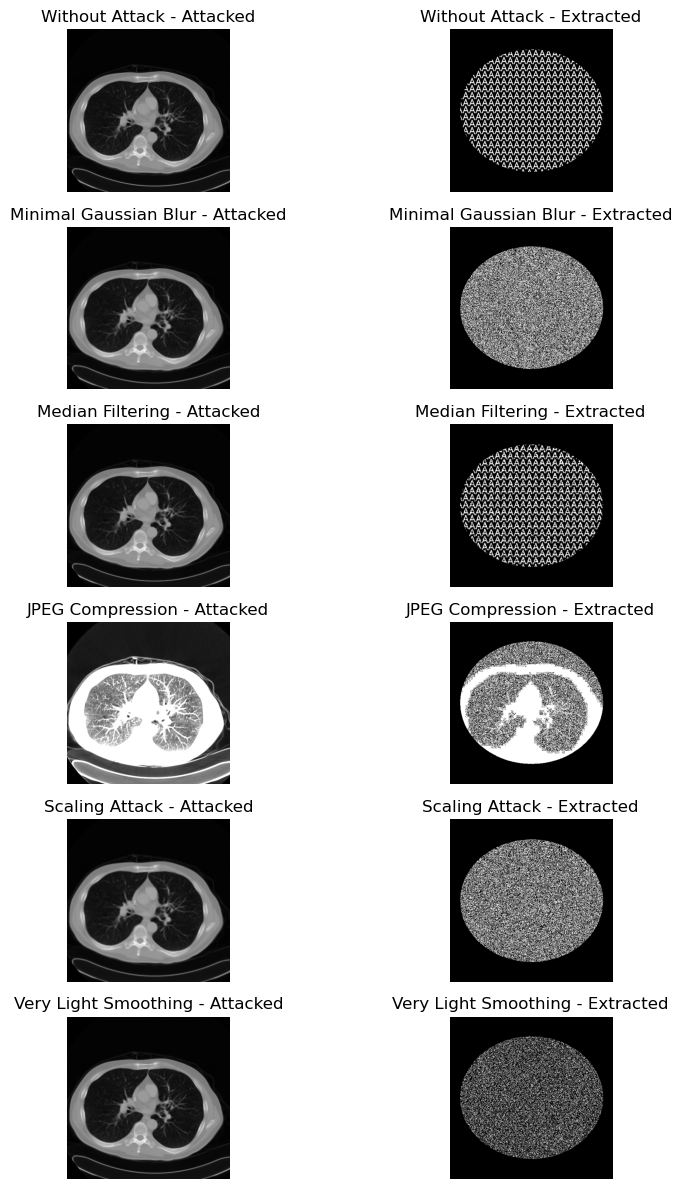

In [18]:
apply_attacks_and_extract_LSB(watermarked_image, extract_watermark)